In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from transformers import ViTModel

In [2]:
# Training mode enabled/disabled (if enabled will overwrite current stored model)
training = False

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Where to store/load the finetuned model
model_save_path = "./models/vit-mnist"

In [5]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT needs minimum 224x224
    transforms.ToTensor(),
])
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [6]:
# Modified ViT Model Definition
class ViTEmbedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        # Convert grayscale to 3 channels
        self.channel_adapter = nn.Conv2d(1, 3, kernel_size=1)  # Better than repeating channels
        self.classifier = nn.Linear(768, 10)  # MNIST has 10 classes

    def forward(self, x):
        # Convert 1-channel to 3-channel
        x = self.channel_adapter(x)  # [B, 3, 224, 224]
        outputs = self.vit(x)
        embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        return self.classifier(embeddings), embeddings

In [7]:
def save_model(model: ViTEmbedder):
    os.makedirs(model_save_path, exist_ok=True)
    model.vit.save_pretrained(model_save_path)
    torch.save({
        'channel_adapter': model.channel_adapter.state_dict(),
        'classifier': model.classifier.state_dict()
    }, os.path.join(model_save_path, "custom_layers.pth"))

In [8]:
def load_model() -> ViTEmbedder:
    vit = ViTModel.from_pretrained(model_save_path)
    model = ViTEmbedder()
    model.vit = vit
    custom_layers = torch.load(os.path.join(model_save_path, "custom_layers.pth"), map_location=device)
    model.channel_adapter.load_state_dict(custom_layers['channel_adapter'])
    model.classifier.load_state_dict(custom_layers['classifier'])
    model.eval()
    return model

In [9]:
# Initialize model
if training:
    model = ViTEmbedder().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
    criterion = nn.CrossEntropyLoss()
else:
    model = load_model()

In [10]:
# Training loop
if training:
    for epoch in range(5):
        model.train()
        total_loss = 0
        
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            logits, embeddings = model(imgs)
            loss = criterion(logits, labels)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

In [11]:
# Only run this when training/finetuning the model
if training:
    save_model(model)

In [12]:
# Take 5% of the dataset
subset_percent = 0.05
dataset = train_loader.dataset
subset_size = int(len(dataset) * subset_percent)
indices = np.random.choice(len(dataset), subset_size, replace=False)

subset_loader = torch.utils.data.DataLoader(
    Subset(dataset, indices),
    batch_size=train_loader.batch_size,
    shuffle=False  # Keep False for consistent subsets
)

In [13]:
eval_loader = train_loader if training else subset_loader

In [14]:
# Collect embeddings
all_embeddings = []
all_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in tqdm(eval_loader, desc="Processing batches"):
        imgs = imgs.to(device)
        _, embeddings = model(imgs)
        all_embeddings.append(embeddings.cpu())
        all_labels.append(labels)

embeddings = torch.cat(all_embeddings).numpy()
labels = torch.cat(all_labels).numpy()

Processing batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [11:07<00:00,  7.10s/it]


/home/ebljohn/github/setup_notebook_server/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ebljohn/github/setup_notebook_server/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


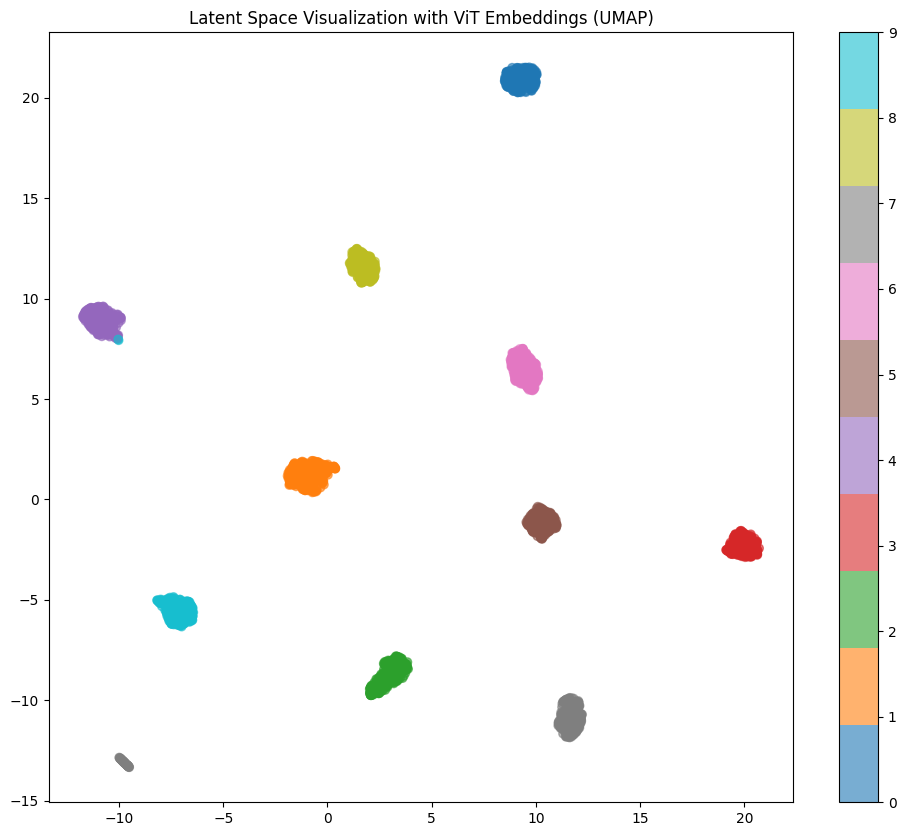

In [15]:
# UMAP projection (same as before)
import umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(
    n_components=2,
    n_neighbors=20,       # Controls local vs global structure
    min_dist=0.1,         # Controls cluster tightness
    metric='euclidean',   # Distance metric
    random_state=42
)
emb_2d = reducer.fit_transform(embeddings)

plt.figure(figsize=(12, 10))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap='tab10', alpha=0.6)
plt.title('Latent Space Visualization with ViT Embeddings (UMAP)')
plt.colorbar()
plt.show()

In [64]:
labels[:8]

array([9, 1, 8, 2, 0, 0, 0, 8])

In [65]:
len(embeddings[3])

768

In [66]:
display(labels[3])
emb_2d[3]

np.int64(2)

array([ 5.435823, -3.199163], dtype=float32)

In [67]:
display(labels[2])
emb_2d[2]

np.int64(8)

array([  0.34042677, -13.092387  ], dtype=float32)